# Estimating lumbar moment with wearable sensors over a range of manual lifting tasks


*Emily S Matijevich, Peter Volgyesi, Karl E. Zelik*  
Vanderbilt University, Nashville, TN, USA  
Email:  emily.matijevich@vanderbilt.edu  

## Libraries

In [1]:
# Standard library
import os
import re

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, metrics, preprocessing, pipeline

# Local
import utils

# matplotlib hackery
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)

## Load dataset

In [2]:
export_prefix = "ASB_2020_results"
os.makedirs(export_prefix, exist_ok=True)

#dataset_name = "lumbar_results_PXV_10_15_19.csv" # lab-based targets, lab-based predictors (all trials)
dataset_name = "lumbar_results2_PXV_10_15_19.csv" # lab-based target, wearable predictors (subset of trials)
#dataset_name = "lumbar_results3_PXV_10_15_19.csv" # lab-based targets, lab-based predictors (same subset of trials as above)

df_orig = utils.load_dataset("s3://cpac/ORIG/SpinePredictions_500taks_PXV_1S_10_15_19/" + dataset_name)
df_orig.describe()

,Trial_Index_2,Mass_2,Pelvis_Moment_X_2,Pelvis_Moment_Y_2,Pelvis_Moment_Z_2,INSOLE_LFORCE,INSOLE_RFORCE,INSOLE_LXMM,INSOLE_LYMM,INSOLE_RXMM,...,L5S1_Z_1,L4L3_X,L4L3_Y,L4L3_Z,L1T12_X,L1T12_Y,L1T12_Z,T9T8_X,T9T8_Y,T9T8_Z
count,91258.000000,91258.000000,88897.000000,88897.000000,88897.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,...,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000,91258.000000
mean,1498.880295,9.770705,-82.856951,6.221593,-4.552406,482.447499,534.089344,56.976953,106.640490,55.502439,...,-0.115123,-0.123100,0.406183,-5.873359,-0.123059,0.406197,-0.052926,-0.122218,0.292773,5.797092
std,1184.956952,5.183312,73.010224,30.737168,10.377016,291.051994,305.037610,6.372760,48.119794,7.812165,...,5.681981,0.723665,1.043535,2.524663,0.723638,1.043561,2.524660,0.568168,0.764885,1.893398
min,1.000000,5.000000,-383.737732,-1354.738403,-467.997162,7.720000,0.000000,28.170000,33.850000,0.000000,...,-19.151970,-3.288495,-3.861544,-14.354029,-3.288248,-3.861681,-8.533602,-2.638369,-2.874966,-0.564287
25%,463.000000,5.000000,-142.227692,-9.199482,-8.324476,198.991250,269.228250,54.580000,66.020000,51.560000,...,-4.166251,-0.575576,-0.183056,-7.674399,-0.575412,-0.183031,-1.853968,-0.485966,-0.139258,4.446483
50%,1220.000000,10.000000,-65.825653,4.952320,-2.700749,495.001000,526.556000,57.760000,93.960000,57.110000,...,-0.541778,-0.199450,0.358295,-6.060512,-0.199432,0.358302,-0.240079,-0.175457,0.260802,5.656814
75%,2330.000000,15.000000,-15.545347,23.169724,0.239998,732.340250,799.778750,60.430000,144.910000,60.420000,...,4.679438,0.274469,0.997222,-3.745073,0.274424,0.997274,2.075361,0.205431,0.723043,7.393155
max,4765.000000,23.000000,331.114929,1069.714722,907.098022,1239.510000,1331.802000,72.540000,236.040000,76.550000,...,13.951686,3.651306,4.974982,0.367887,3.651238,4.974470,6.188318,2.774458,3.677700,10.477099


## Clean-up dataset

- Associate column types (semi-automatically)
- Eliminate trials start with `"IDP"`
- Eliminate trials containing `"walk"`
- Eliminate samples with missing (`NaN`) values
- Eliminate samples with positive (`>0`) values for Pelvis_Moment_X

In [3]:
def select_solumns(df):
    """Select target and feature columns"""
    META_PATTERNS = [
        "Trial_Name.*",
        "Trial_Index.*",
        "Trial_Type.*",
        "Mass.*"
    ]

    TARGET_PATTERNS = [
        "Pelvis_Moment_X.*",
        "Pelvis_Moment_Y.*",
        "Pelvis_Moment_Z.*"
    ]
    
    meta_names = []
    feature_names = []
    target_names = []
    
    for column in df.columns:
        kind = feature_names
        for pattern in META_PATTERNS:
            if re.match(pattern, column):
                kind = meta_names
        for pattern in TARGET_PATTERNS:
            if re.match(pattern, column):
                kind = target_names
        kind.append(column)

    return target_names, feature_names, meta_names

target_names, feature_names, meta_names = select_solumns(df_orig)
target_name = target_names[0]     # HACK!
#target_name = "Pelvis_Moment_X"
#target_name = "Pelvis_Moment_Y"
#target_name = "Pelvis_Moment_Z"

trial_name = meta_names[0]        # HACK!

df = df_orig.copy()
df = df[~df[trial_name].str.startswith("IDP")]
df = df[~df[trial_name].str.contains("walk")]
df = df.dropna()
df = df[df[target_name] <= 0.0]

print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print("Number of trials:", len(df_orig[trial_name].unique()))

df.describe()

Number of samples: 83653 (before clean-up: 91258)
Number of trials: 49


,Trial_Index_2,Mass_2,Pelvis_Moment_X_2,Pelvis_Moment_Y_2,Pelvis_Moment_Z_2,INSOLE_LFORCE,INSOLE_RFORCE,INSOLE_LXMM,INSOLE_LYMM,INSOLE_RXMM,...,L5S1_Z_1,L4L3_X,L4L3_Y,L4L3_Z,L1T12_X,L1T12_Y,L1T12_Z,T9T8_X,T9T8_Y,T9T8_Z
count,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,...,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000,83653.000000
mean,1543.996414,9.639200,-86.818507,6.486598,-4.764872,482.725898,535.148331,57.029114,107.733197,55.403848,...,0.088452,-0.089115,0.392875,-5.783179,-0.089075,0.392884,0.037252,-0.095659,0.285418,5.864696
std,1176.134709,5.044433,71.449704,30.613124,10.349447,296.476161,310.269712,6.461098,48.400359,7.929074,...,5.674269,0.718334,1.028258,2.521548,0.718305,1.028281,2.521547,0.563176,0.754029,1.891063
min,1.000000,5.000000,-383.737732,-504.596527,-467.997162,7.720000,0.000000,28.170000,35.210000,0.000000,...,-19.151970,-2.295476,-3.861544,-14.354029,-2.295549,-3.861681,-8.533602,-1.771676,-2.874966,-0.564287
25%,518.000000,5.000000,-144.605347,-9.968402,-8.665667,187.553000,254.163000,54.530000,66.120000,51.280000,...,-3.955234,-0.557346,-0.194438,-7.579974,-0.557306,-0.194515,-1.759542,-0.471664,-0.144257,4.516984
50%,1289.000000,10.000000,-72.353416,5.355928,-2.946156,494.930000,531.758000,57.860000,95.910000,57.070000,...,-0.232141,-0.181863,0.358785,-5.921799,-0.181826,0.358795,-0.101364,-0.160972,0.262193,5.760069
75%,2373.000000,15.000000,-19.072489,24.666170,0.127620,744.117000,807.393000,60.560000,147.180000,60.460000,...,4.910700,0.311246,0.985352,-3.642003,0.311232,0.985374,2.178428,0.237134,0.716195,7.470721
max,4765.000000,23.000000,-0.000725,1069.714722,907.098022,1192.645000,1286.620000,72.540000,236.040000,75.010000,...,13.951686,3.651306,4.974982,0.367887,3.651238,4.974470,6.188318,2.774458,3.677700,10.477099


## Train / test partitioning

- Test set: exercises with 5kg weight
- ~~Test set: all samples where `Trial_Name` contains `"freestyle"` (case insensitive)~~
- Train set: all other samples

In [4]:
test_selector = df[trial_name].str.match("S0[0-9]_5kg")
#test_selector = df["Trial_Name"].str.contains("freestyle", case=False)
df_test = df[test_selector]
df_train = df[~test_selector]
print(f"Train set size: {len(df_train)}\nTest set size: {len(df_test)} ({len(df_test) / len(df):.1%})")

Train set size: 71010
Test set size: 12643 (15.1%)


## Build Gradient Boosting model - train set

In [5]:
def build_model(X_train, y_train):
    model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('gboost', ensemble.GradientBoostingRegressor(n_estimators=200))
    ])
    model.fit(X_train, y_train)
    return model

model = build_model(df_train[feature_names], df_train[target_name])

## Evaluate model - test set

MSE: 386.16
RMSE: 19.65
R^2 Score: 0.896


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


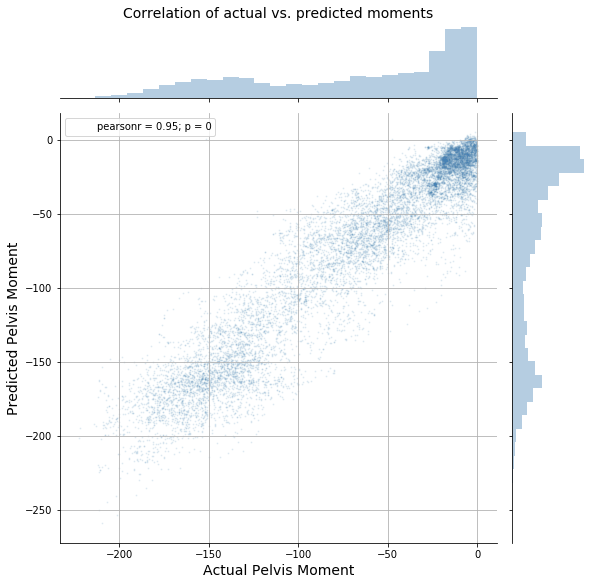

In [6]:
def evaluate_model(model, X_test, y_test):
    
    y_test_pred = model.predict(X_test)
    
    # Quantitative results
    mse = metrics.mean_squared_error(y_test_pred, y_test)
    r2 = metrics.r2_score(y_test_pred, y_test)
    print(f"MSE: {mse:.2f}\nRMSE: {np.sqrt(mse):.2f}\nR^2 Score: {r2:.3f}")
    
    # Correlation plot: actual vs. predicted
    ax = sns.jointplot(y_test, y_test_pred, alpha=0.1, s=1.0, color="steelblue", size=8)
    #sns.jointplot(y_test, y_test_pred, kind="hex")
    #sns.jointplot(y_test, y_test_pred, kind="reg")
    ax.set_axis_labels("Actual Pelvis Moment", 'Predicted Pelvis Moment', fontsize=14)
    #ax.ax_joint.legend_.remove()
    ax.ax_joint.grid()
    ax.ax_marg_x.set_title("Correlation of actual vs. predicted moments", fontsize=14)
    
    
evaluate_model(model, df_test[feature_names], df_test[target_name])    

## Export prediction results

In [7]:
export_df = df.copy()
export_df[target_name + "_est"] = model.predict(df[feature_names])
#export_df.to_csv(f"{export_prefix}/predictions_{dataset_name}", header=True, index=False)

## Example trial time series: actual vs. predicted

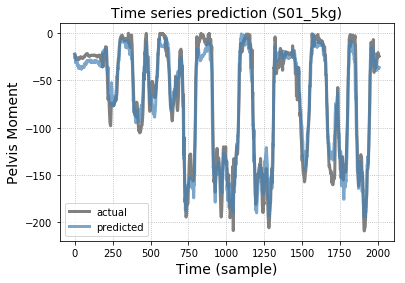

In [8]:
def plot_trial(model, X_trial, y_trial, trial_name):
    y_trial_pred = model.predict(X_trial)
    plt.plot(np.ravel(y_trial), c="gray", linewidth=3, label="actual")
    plt.plot(y_trial_pred, c="steelblue", alpha=.7, linewidth=3, label="predicted")
    plt.grid(linestyle='dotted')
    plt.xlabel("Time (sample)", fontsize=14)
    plt.ylabel("Pelvis Moment", fontsize=14)
    plt.legend()
    plt.title(f"Time series prediction ({trial_name})", fontsize=14);

trial_name, df_trial = list(df_test.groupby(trial_name))[0]   # HACK: get first trial from test set
plot_trial(model, df_trial[feature_names], df_trial[target_name], trial_name)

## Feature importances

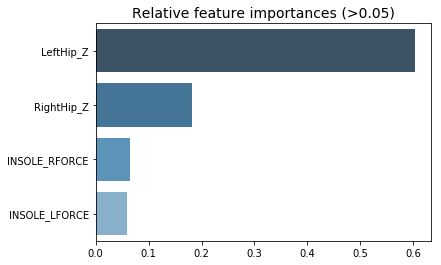

In [9]:
importance_threshold = 0.05

feature_importances = pd.Series(model.named_steps.gboost.feature_importances_, index=feature_names).sort_values(ascending=False)
important_feature_names = feature_importances[feature_importances > importance_threshold].index

ax = sns.barplot(y=important_feature_names, x=feature_importances[important_feature_names], palette="Blues_d")
ax.set_title(f"Relative feature importances (>{importance_threshold})", fontsize=14);

# export results
export_feature_importantes = pd.DataFrame({"Feature": feature_names, "Importance": model.named_steps.gboost.feature_importances_})
export_feature_importantes.to_csv(f"{export_prefix}/feature_importances_{dataset_name}", header=True, index=False)

## Retrain, evaluate and export with important features, only

Selected features: ['LeftHip_Z', 'RightHip_Z', 'INSOLE_RFORCE', 'INSOLE_LFORCE']
MSE: 453.27
RMSE: 21.29
R^2 Score: 0.873


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


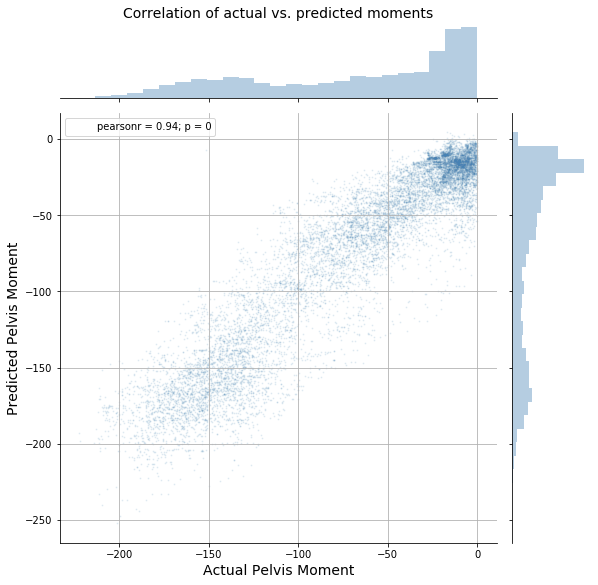

In [10]:
print(f"Selected features: {important_feature_names.to_list()}")
important_model = build_model(df_train[important_feature_names], df_train[target_name])
evaluate_model(important_model, df_test[important_feature_names], df_test[target_name])
export_df[target_name + "_est_important"] = important_model.predict(df[important_feature_names])
export_df.to_csv(f"{export_prefix}/predictions_{dataset_name}", header=True, index=False)


In [28]:
stages = important_model.staged_predict(df_trial[important_feature_names])
plt.plot(stages)


AttributeError: 'Pipeline' object has no attribute 'staged_predict'